In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import cPickle as pickle
import fastparquet

In [14]:
data=fastparquet.ParquetFile("../input/train_test.parq").to_pandas()

In [3]:
def nancorr2(a,b):
    idx0=(~np.isnan(a))
    idx=idx0 & (~np.isnan(b))
    a=a[idx].flatten().astype(np.float64);b=b[idx].flatten().astype(np.float64)
    return np.corrcoef(a,b)[0,1],idx.sum()/float(idx0.sum())
def lag_v(v,lag=1): #assume v is same order as data
    tmpdf=data[['air_store_id','visit_date']].copy()
    tmpdf2=tmpdf.copy()
    tmpdf2['v']=v
    tmpdf2['visit_date']=tmpdf2['visit_date']+lag
    df=pd.merge(tmpdf,tmpdf2,how="left",on=['air_store_id','visit_date'])
    return df['v'].values
    
def lag_y(lag=1):
    return lag_v(data['visitors'].values,lag=lag)
def ma(period=3):
    s=0
    sd=0.0
    for i in range(period):
        a=lag_y(i)
        ind=np.isnan(a)
        sd+= ~ind
        a[ind]=0
        s+=a
    sd[sd<period//2]=np.nan
    return s/sd
def lag_ma(lag=1,period=3):
    return lag_v(ma(period=period),lag=lag)
def season_ma(period=3):
    s=0
    sd=0.0
    for i in range(period):
        a=lag_y(i*7)
        ind=np.isnan(a)
        sd+= ~ind
        a[ind]=0
        s+=a
    sd[sd<period//2]=np.nan        
    return s/sd
def lag_season_ma(lag=1,period=3):
    return lag_v(season_ma(period=period),lag=lag*7)

In [7]:
for i in [2,4,7,14,28,56,112,224]:
    data['visitors_ma_'+str(i)]=ma(i)

In [8]:
for i in [2,3,4,8,16,32]:
    data['visitors_sma_'+str(i)]=season_ma(i)

In [9]:
fastparquet.write("../input/train_test_v3.parq",data,compression="SNAPPY")

In [10]:
pd.to_datetime('2017-4-23')-pd.to_datetime('2017-5-31')

Timedelta('-38 days +00:00:00')

In [18]:
data.describe().T

count        mean         std         min  \
air_store_id                428593.0  414.000000  239.311792    0.000000   
visit_date                  428593.0  258.000000  149.244940    0.000000   
visitors                    252108.0    2.802788    0.807726    0.693147   
geo1_store_count            428593.0  272.544029  186.169951   14.000000   
geo1_visitors_count         428593.0  158.657276  148.763060    0.000000   
geo1_visitors_mean          396216.0    2.804147    0.216664    1.354025   
geo2_store_count            428593.0   41.576598   30.850748    2.000000   
geo2_visitors_count         428593.0   24.539304   24.734308    0.000000   
geo2_visitors_mean          391700.0    2.803253    0.343859    0.693147   
station_store_count         428593.0  260.078408  193.333135    2.000000   
station_visitors_count      428593.0  151.030119  150.496598    0.000000   
station_visitors_mean       395625.0    2.804620    0.254730    0.693147   
genre_name_store_count      428593.0  127.550060   62.061709    2.000000   
genre_name_visitors_count   428593.0   74.709417   56.241349    0.000000   
genre_name_visitors_mean    395279.0    2.806691    0.222878    0.693147   
TMAX                        428593.0   19.311073    8.417433  -10.600000   
TMIN                        428593.0   11.036964    8.443923  -22.500000   
TAVG                        428593.0   14.803888    8.184934  -15.400000   
PRCP                        140858.0  123.878433  168.803711    5.000000   
day_of_week_store_count     428593.0  829.000000    0.000000  829.000000   
day_of_week_visitors_count  428593.0  487.636364  253.819471    0.000000   
day_of_week_visitors_mean   396262.0    2.808927    0.179764    2.353138   
holiday                     428593.0    0.067698    0.251228    0.000000   
is_rain                     428593.0    0.328652    0.469724    0.000000   
visitors_ma_2               280628.0    2.785918    0.738513    0.693147   
visitors_ma_4               283453.0    2.793075    0.652284    0.693147   
visitors_ma_7               287845.0    2.792106    0.612967    0.693147   
visitors_ma_14              284943.0    2.794020    0.590467    0.693147   
visitors_ma_28              284913.0    2.793872    0.577975    0.693147   
visitors_ma_56              282292.0    2.794990    0.569445    0.706663   
visitors_ma_112             267211.0    2.793439    0.560169    0.745711   
visitors_ma_224             215824.0    2.795313    0.548402    0.751810   
visitors_sma_2              274953.0    2.776492    0.760858    0.693147   
visitors_sma_3              285185.0    2.766603    0.740220    0.693147   
visitors_sma_4              271796.0    2.785559    0.699757    0.693147   
visitors_sma_8              269072.0    2.793099    0.665646    0.693147   
visitors_sma_16             254329.0    2.795141    0.642210    0.693147   
visitors_sma_32             209690.0    2.801559    0.622459    0.712455   

                                   25%         50%         75%          max  
air_store_id                207.000000  414.000000  621.000000   828.000000  
visit_date                  129.000000  258.000000  387.000000   516.000000  
visitors                      2.302585    2.890372    3.401197     6.777647  
geo1_store_count             74.000000  444.000000  444.000000   444.000000  
geo1_visitors_count          33.000000  112.000000  315.000000   425.000000  
geo1_visitors_mean            2.651771    2.789400    2.937641     4.150264  
geo2_store_count             17.000000   39.000000   64.000000   103.000000  
geo2_visitors_count           6.000000   17.000000   37.000000   101.000000  
geo2_visitors_mean            2.605946    2.797153    3.005990     5.123964  
station_store_count          76.000000  440.000000  440.000000   440.000000  
station_visitors_count       19.000000  100.000000  304.000000   421.000000  
station_visitors_mean         2.655698    2.794452    2.945694     4.700480  
genre_name_store_count       79.000000  108.000000  

In [11]:
columns=[u'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 
         'genre_name_visitors_mean', 'day_of_week_visitors_mean',
         u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday']

In [21]:
#from view of today
raw_params={u'PRCP': range(-14, 14+1),
            u'is_rain': range(-14, 14+1),
 u'TAVG': range(-14, 14+1),
 u'TMAX': range(-14, 14+1),
 u'TMIN': range(-14, 14+1),
 'day_of_week_visitors_mean': range(1, 9),
 'genre_name_visitors_mean': range(1, 9),
 'geo1_visitors_mean': range(1, 9),
 'geo2_visitors_mean': range(1, 9),
 u'holiday': range(-7, 7+1),
 'station_visitors_mean': range(1, 9),
 u'visitors': list(range(1, 9))+[28,56,91,182,265],
u'ma_visitors': range(1,9),
u'sma_visitors': range(1,9),
            }

In [22]:
import cPickle as pickle

# offset 1

In [27]:
def adjust_param(name,v,offset):
    if name in [u'TAVG', u'holiday',  u'TMIN', u'TMAX', u'is_rain', u'PRCP']:
        v=np.array(v)-offset
        v[v<-39]=-39
        v=list(set(v))
        return v
    else:
        v=np.array(v)-offset%7
        v[v<0]=v[v<0]+7
        v=list(set(v))
        return v

In [38]:
def get_ma(p):
    c="visitors_ma_"+str(p)
    if c not in data.columns:
        s=ma(period=p)
        data[c]=s
    return c,data[c].values
def get_sma(p):
    c="visitors_sma_"+str(p)
    if c not in data.columns:
        s=season_ma(period=p)
        data[c]=s
    return c,data[c].values
                

In [29]:
def g(offset,target,params):
    result=[]
    for k in params:
        print k,
        if k not in ['visitors','ma_visitors','sma_visitors']:
            s=data[k].values
            for i in params[k]:
                print i,
                v=lag_v(s,lag=i)
                result.append(['raw',k,i,None,nancorr2(target,v)])
            print ""
        elif k=='visitors':
            print "raw", 
            s=lag_y(0)
            for i in params[k]:
                print i,
                v=lag_v(s,lag=i)
                result.append(['raw',k,i,None,nancorr2(target,v)])
        elif k=='ma_visitors':
            ma_periods=[2,4,7,14,28,56,112,224]
            print "ma", 
            for p in ma_periods:
                c,s=get_ma(p)
                print "p",p,"l",
                for i in  params[k]:
                    print i,
                    v=lag_v(s,lag=i)
                    result.append(['ma',c,i,p,nancorr2(target,v)])
        elif k=='sma_visitors':
            sma_periods=[2,3,4,8,16,32]
            print 'sma',
            for p in sma_periods:
                print "p",p,"l",            
                c,s=get_sma(p)
                for i in params[k]:
                    print i,
                    v=lag_v(s,lag=i)
                    result.append(['sma',c,i,p,nancorr2(target,v)])
            print ""
        else:
            raise 1
        pickle.dump(result,open('sel_offset_{}.pkl'.format(offset),'wb'))
    return result

In [30]:
for offset in range(1,40):
    print offset
    target=lag_y(-offset)
    params={k:adjust_param(k,v,offset) for k,v in raw_params.items()}
    print str(params)
    %time result=g(offset,target,params)
    print "\n"

1
{u'TAVG': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -2, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -1], u'holiday': [0, 1, 2, 3, 4, 5, 6, -1, -8, -7, -6, -5, -4, -3, -2], 'geo2_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], u'TMIN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -2, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -1], u'TMAX': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -2, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -1], 'station_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], 'day_of_week_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], u'ma_visitors': [0, 1, 2, 3, 4, 5, 6, 7], u'visitors': [0, 1, 2, 3, 4, 5, 6, 7, 264, 181, 55, 90, 27], 'genre_name_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], 'geo1_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], u'is_rain': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -2, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -1], u'PRCP': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -2, -15, -14, -13, -

TAVG 0 1 2 3 4 5 6 -2 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -1 
holiday -1 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 
geo2_visitors_mean 0 1 2 3 4 5 6 7 
TMIN 0 1 2 3 4 5 6 -2 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -1 
TMAX 0 1 2 3 4 5 6 -2 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -1 
station_visitors_mean 0 1 2 3 4 5 6 7 
day_of_week_visitors_mean 0 1 2 3 4 5 6 7 
ma_visitors ma p 2 l 0 1 2 3 4 5 6 7 p 4 l 0 1 2 3 4 5 6 7 p 7 l 0 1 2 3 4 5 6 7 p 14 l 0 1 2 3 4 5 6 7 p 28 l 0 1 2 3 4 5 6 7 p 56 l 0 1 2 3 4 5 6 7 p 112 l 0 1 2 3 4 5 6 7 p 224 l 0 1 2 3 4 5 6 7 visitors raw 0 1 2 3 4 5 6 7 264 181 55 90 27 genre_name_visitors_mean 0 1 2 3 4 5 6 7 
geo1_visitors_mean 0 1 2 3 4 5 6 7 
is_rain 0 1 2 3 4 5 6 -2 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -1 
PRCP 0 1 2 3 4 5 6 -2 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -1 
sm

TAVG -1 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 
holiday -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 
geo2_visitors_mean 0 1 2 3 4 5 6 7 
TMIN -1 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 
TMAX -1 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 
station_visitors_mean 0 1 2 3 4 5 6 7 
day_of_week_visitors_mean 0 1 2 3 4 5 6 7 
ma_visitors ma p 2 l 0 1 2 3 4 5 6 7 p 4 l 0 1 2 3 4 5 6 7 p 7 l 0 1 2 3 4 5 6 7 p 14 l 0 1 2 3 4 5 6 7 p 28 l 0 1 2 3 4 5 6 7 p 56 l 0 1 2 3 4 5 6 7 p 112 l 0 1 2 3 4 5 6 7 p 224 l 0 1 2 3 4 5 6 7 visitors raw 0 1 2 3 4 5 6 7 264 181 55 90 27 genre_name_visitors_mean 0 1 2 3 4 5 6 7 
geo1_visitors_mean 0 1 2 3 4 5 6 7 
is_rain -1 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 
PRCP -1 -29 -28 -27 -26 -25 -24 -23 -2

sma_visitors sma p 2 l 1 2 3 4 5 6 7 8 p 3 l 1 2 3 4 5 6 7 8 p 4 l 1 2 3 4 5 6 7 8 p 8 l 1 2 3 4 5 6 7 8 p 16 l 1 2 3 4 5 6 7 8 p 32 l 1 2 3 4 5 6 7 8 
CPU times: user 43.2 s, sys: 112 ms, total: 43.3 s
Wall time: 43 s


22
{u'TAVG': [-36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8], u'holiday': [-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15], 'geo2_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], u'TMIN': [-36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8], u'TMAX': [-36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8], 'station_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], 'day_of_week_visitors_mean': [0, 1, 2, 3, 4, 5, 6, 7], u'ma_visitors': [0, 1, 2, 3, 4, 5, 6, 7], u'visitors': [0, 1, 2, 3, 4,

TAVG -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 
holiday -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
geo2_visitors_mean 0 1 2 3 4 5 6 
TMIN -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 
TMAX -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 
station_visitors_mean 0 1 2 3 4 5 6 
day_of_week_visitors_mean 0 1 2 3 4 5 6 
ma_visitors ma p 2 l 0 1 2 3 4 5 6 p 4 l 0 1 2 3 4 5 6 p 7 l 0 1 2 3 4 5 6 p 14 l 0 1 2 3 4 5 6 p 28 l 0 1 2 3 4 5 6 p 56 l 0 1 2 3 4 5 6 p 112 l 0 1 2 3 4 5 6 p 224 l 0 1 2 3 4 5 6 visitors raw 0 1 2 3 4 5 6 178 52 87 24 261 genre_name_visitors_mean 0 1 2 3 4 5 6 
geo1_visitors_mean 0 1 2 3 4 5 6 
is_rain -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 
PRCP -39 -38 -37 -36 -35 -34

TAVG -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
holiday -32 -31 -30 -29 -28 -27 -26 -25 -39 -38 -37 -36 -35 -34 -33 
geo2_visitors_mean 0 1 2 3 4 5 6 
TMIN -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
TMAX -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
station_visitors_mean 0 1 2 3 4 5 6 
day_of_week_visitors_mean 0 1 2 3 4 5 6 
ma_visitors ma p 2 l 0 1 2 3 4 5 6 p 4 l 0 1 2 3 4 5 6 p 7 l 0 1 2 3 4 5 6 p 14 l 0 1 2 3 4 5 6 p 28 l 0 1 2 3 4 5 6 p 56 l 0 1 2 3 4 5 6 p 112 l 0 1 2 3 4 5 6 p 224 l 0 1 2 3 4 5 6 visitors raw 0 1 2 3 4 5 6 178 52 87 24 261 genre_name_visitors_mean 0 1 2 3 4 5 6 
geo1_visitors_mean 0 1 2 3 4 5 6 
is_rain -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
PRCP -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 
sma_visitors sma p 2 l 0 1 2 3 4 5 6 p 3 l 0 1

TAVG -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -39 -38 -37 -36 -35 -34 -33 
holiday -32 -31 -30 -29 -39 -38 -37 -36 -35 -34 -33 
geo2_visitors_mean 0 1 2 3 4 5 6 7 
TMIN -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -39 -38 -37 -36 -35 -34 -33 
TMAX -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -39 -38 -37 -36 -35 -34 -33 
station_visitors_mean 0 1 2 3 4 5 6 7 
day_of_week_visitors_mean 0 1 2 3 4 5 6 7 
ma_visitors ma p 2 l 0 1 2 3 4 5 6 7 p 4 l 0 1 2 3 4 5 6 7 p 7 l 0 1 2 3 4 5 6 7 p 14 l 0 1 2 3 4 5 6 7 p 28 l 0 1 2 3 4 5 6 7 p 56 l 0 1 2 3 4 5 6 7 p 112 l 0 1 2 3 4 5 6 7 p 224 l 0 1 2 3 4 5 6 7 visitors raw 0 1 2 3 4 5 6 7 264 181 55 90 27 genre_name_visitors_mean 0 1 2 3 4 5 6 7 
geo1_visitors_mean 0 1 2 3 4 5 6 7 
is_rain -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -39 -38 -37 -36 -35 -34 -33 
PRCP -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -39 -38 -37 -36 -35 -34 -33 
sma_visitors sma p 2 l 0 1 2 3 4 5 6 7 p 3 l 0 1 2 3 4 5 6 7 p 4 l 0 1 2 3 4 5 6 7 p 8 l 0 1 2 3 4 5 6 7 p 16 l 0 

In [4]:
files=!ls sel*.pkl

In [5]:
results=reduce(lambda x,y:x+y,[[[u]+v for v in pickle.load(open(u))] for u in files])

In [6]:
len(results)

12675

In [7]:
results=pd.DataFrame(results,columns=['file','grp','name','lag','offset','value'])

In [20]:
results['rho']=results['value'].map(lambda u: u[0])
results['rho2']=np.round(results['rho']**2,4)

results['%nan']=results['value'].map(lambda u: 1-u[1])
results['abs_rho']=np.abs(results['rho'] )

In [21]:
results=results.sort_values('abs_rho',ascending=False)

In [33]:
np.sqrt(1-0.47**2/np.nanvar(lag_y(0)))**2

0.6614134592390114

In [37]:
data['air_store_id'].max()

828

In [75]:
data['lag_sma16']=lag_ma(lag=1,period=3)

In [76]:
data [['visitors','lag_sma16']].corr()

visitors  lag_sma16
visitors   1.000000   0.562564
lag_sma16  0.562564   1.000000

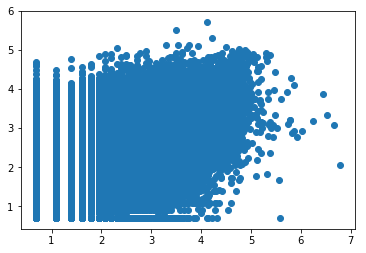

In [77]:
plt.scatter(data['visitors'],data['lag_sma16']);

0.0519389438928


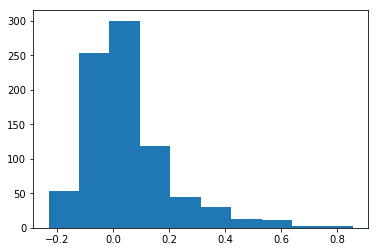

In [80]:
lst=np.array(lst)
lst=lst[~np.isnan(lst)]
print lst.mean()
plt.hist(lst);

In [79]:
lst=[]
for i in range(829):
    tmpdf=data[data.air_store_id==i][['visitors','lag_sma16']]
    lst.append(tmpdf.corr().values[0,1])
    print i, lst[-1]

0 -0.10467599217
1 0.0425164152148
2 -0.0446053826745
3 0.173426318048
4 0.425320565262
5 0.152212611935
6 0.855852559144
7 0.0173978075262
8 -0.00537679105616
9 -0.125484704504
10 0.217162666298
11 0.132859767498
12 0.0498386802861
13 -0.170083669092
14 0.200499545225
15 -0.0108104346935
16 0.0333111182486
17 -0.0201718853738
18 0.0424263332223
19 0.3604370339
20 -0.0405926740545
21 -0.0540953198218
22 0.191220661022
23 -0.0872011930634
24 0.00410247233364
25 0.0410910848394
26 -0.0596773556089
27 -0.0974886592236
28 -0.0642533083413
29 -0.120636129837
30 -0.137235087093
31 0.169574313344
32 -0.0616126545506
33 0.345388505098
34 -0.0389103386887
35 0.031232129992
36 0.270797953823
37 0.00336923464087
38 -0.140812121721
39 0.120329192972
40 0.38255461665
41 0.568532654269
42 0.0274507206557
43 -0.00109574873365
44 0.177706122337
45 0.187161531792
46 0.0511394296705
47 0.00482447825236
48 -0.0673738056993
49 0.32824414454
50 0.0433274205986
51 0.124383646468
52 -0.0279763621056
53 0.085

455 0.144559046639
456 0.0784179348503
457 -0.103911181748
458 -0.0501702036997
459 0.0219186072611
460 0.171487379982
461 0.12191600634
462 0.0382242170595
463 0.0625678249064
464 0.00174368701055
465 -0.177910075777
466 0.00587966332969
467 0.108500962873
468 -0.0443219002539
469 0.185057399312
470 0.234085663353
471 -0.0749717386859
472 -0.0544761351182
473 0.255650104701
474 -0.0145380987204
475 -0.000463574916368
476 0.0968071458898
477 0.0283127360249
478 -0.0356105619919
479 0.138842888822
480 5.68778105455e-05
481 0.703424905106
482 0.579686490985
483 0.00555971910944
484 0.058364077683
485 0.14701595773
486 -0.0353098274654
487 -0.0287941414823
488 -0.0791430334869
489 0.0549361415725
490 -0.00704299960671
491 -0.058587660025
492 0.176756675278
493 0.0276144320361
494 -0.0441766579051
495 0.0546028368393
496 0.596451071216
497 0.378187269455
498 -0.0473501451357
499 0.0261069760902
500 0.40100127967
501 0.098487902643
502 0.0352591533446
503 -0.0489422901943
504 -0.17194809676

In [44]:
results[results['file']=='sel_offset_1.pkl']

file  grp                      name  lag  offset  \
3565  sel_offset_1.pkl  sma           visitors_sma_16    6    16.0   
3573  sel_offset_1.pkl  sma           visitors_sma_32    6    32.0   
3557  sel_offset_1.pkl  sma            visitors_sma_8    6     8.0   
3549  sel_offset_1.pkl  sma            visitors_sma_4    6     4.0   
3541  sel_offset_1.pkl  sma            visitors_sma_3    6     3.0   
3533  sel_offset_1.pkl  sma            visitors_sma_2    6     2.0   
3408  sel_offset_1.pkl   ma            visitors_ma_28    0    28.0   
3416  sel_offset_1.pkl   ma            visitors_ma_56    0    56.0   
3409  sel_offset_1.pkl   ma            visitors_ma_28    1    28.0   
3411  sel_offset_1.pkl   ma            visitors_ma_28    3    28.0   
3412  sel_offset_1.pkl   ma            visitors_ma_28    4    28.0   
3410  sel_offset_1.pkl   ma            visitors_ma_28    2    28.0   
3417  sel_offset_1.pkl   ma            visitors_ma_56    1    56.0   
3413  sel_offset_1.pkl   ma            visitors_ma_28    5    28.0   
3420  sel_offset_1.pkl   ma            visitors_ma_56    4    56.0   
3421  sel_offset_1.pkl   ma            visitors_ma_56    5    56.0   
3419  sel_offset_1.pkl   ma            visitors_ma_56    3    56.0   
3418  sel_offset_1.pkl   ma            visitors_ma_56    2    56.0   
3400  sel_offset_1.pkl   ma            visitors_ma_14    0    14.0   
3414  sel_offset_1.pkl   ma            visitors_ma_28    6    28.0   
3422  sel_offset_1.pkl   ma            visitors_ma_56    6    56.0   
3424  sel_offset_1.pkl   ma           visitors_ma_112    0   112.0   
3429  sel_offset_1.pkl   ma           visitors_ma_112    5   112.0   
3428  sel_offset_1.pkl   ma           visitors_ma_112    4   112.0   
3401  sel_offset_1.pkl   ma            visitors_ma_14    1    14.0   
3427  sel_offset_1.pkl   ma           visitors_ma_112    3   112.0   
3425  sel_offset_1.pkl   ma           visitors_ma_112    1   112.0   
3426  sel_offset_1.pkl   ma           visitors_ma_112    2   112.0   
3430  sel_offset_1.pkl   ma           visitors_ma_112    6   112.0   
3402  sel_offset_1.pkl   ma            visitors_ma_14    2    14.0   
...                ...  ...                       ...  ...     ...   
3516  sel_offset_1.pkl  raw                      PRCP  -12     NaN   
3264  sel_offset_1.pkl  raw                      TAVG   -2     NaN   
3525  sel_offset_1.pkl  raw                      PRCP   -3     NaN   
3319  sel_offset_1.pkl  raw                      TMIN  -13     NaN   
3278  sel_offset_1.pkl  raw                      TAVG   -1     NaN   
3345  sel_offset_1.pkl  raw                      TMAX   -2     NaN   
3322  sel_offset_1.pkl  raw                      TMIN  -10     NaN   
3473  sel_offset_1.pkl  raw                   is_rain    4     NaN   
3346  sel_offset_1.pkl  raw                      TMAX  -15     NaN   
3507  sel_offset_1.pkl  raw                      PRCP    9     NaN   
3269  sel_offset_1.pkl  raw                      TAVG  -11     NaN   
3493  sel_offset_1.pkl  raw                   is_rain   -6     NaN   
3480  sel_offset_1.pkl  raw                   is_rain   11     NaN   
3320  sel_offset_1.pkl  raw                      TMIN  -12     NaN   
3321  sel_offset_1.pkl  raw                      TMIN  -11     NaN   
3508  sel_offset_1.pkl  raw                      PRCP   10     NaN   
3350  sel_offset_1.pkl  raw                      TMAX  -11     NaN   
3457  sel_offset_1.pkl  raw  genre_name_visitors_mean    4     NaN   
3352  sel_offset_1.pkl  raw                      TMAX   -9     NaN   
3524  sel_offset_1.pkl  raw                      PRCP   -4     NaN   
3499  sel_offset_1.pkl  raw                      PRCP    1     NaN   
3489  sel_offset_1.pkl  raw                   is_rain  -10     NaN   
3284  sel_offset_1.pkl  raw                   holiday    5     NaN   
3270  sel_offset_1.pkl  raw                      TAVG  -10     NaN   
3359  sel_offset_1.pkl  raw                      TMAX   -1     NaN   
3271  sel_offset_1.pkl  raw 

In [82]:
results[results['offset']==1.0]

Empty DataFrame
Columns: [grp, name, lag, offset, value, rho, %nan, abs_rho]
Index: []